In [1]:
import pandas as pd
import re
import nltk
import json
import itertools
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import tokenize
from itertools import *
from click import style
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
import os
import json_lines
import seaborn as sns
tqdm.pandas()


nltk.download('stopwords')
nltk.download('punkt')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Include Utils

In [ ]:
%run ../utils/helper_functions.py

# Load dataset

In [2]:
with open("../../data/debateorg/debateorg.json", "r") as d:
    debates_dict = json.load(d)
with open("../../data/debateorg/users.json", "r") as u:
      users_dict = json.load(u)

In [4]:
df_debates = extract_data(debates_dict, users_dict)

100%|██████████████████████████████████████████████████████████████████████████| 78376/78376 [00:07<00:00, 9827.50it/s]


# Load Target Terms

## Queerphobia

In [10]:
def queerphobia_tt():
    targets_1 = ["gay", "gays", "lesbian", "lesbians", "bisexual", "bisexuals", "homosexual", "homosexuals",
                "transgender", "transgenders", "sapphic", "sapphics", "pansexual", "pansexuals", "queer", "queers",
                "genderqueer", "genderqueers", "transsexual", "transsexuals", "crosssexual", "crosssexuals", "epicene",
                 "epicenes", "lgbtq", "lgbtqi", "hermaphroditic", "hermaphrodite", "hermaphrodites", "androgynous", "androgyne",
                 "androgynes", "intersex"]
    targets_2 = ["straight", "straights", "monosexual", "monosexuals", "heterosexual", "heterosexuals", "cisgender",
                "cisgenders", "sexually normal", "hetero", "heteros", "unisexual", "unisexuals"]  
    attributes_1 = ["mentally ill", "polygamous", "flamboyant", "pedophile", "sexual predator", "mental disorder",
                    "irreligious", "villain", "serial killer", "depress", "adultery", "drug addict", "sadist", "arts",
                    "artistic", "theatre", "dramatic", "show queen", "fashion", "predator", "party drugs",
                    "illicit drugs", "alcohol", "sexual abuse", "child rapist", "indecisi", "promiscuous",
                    "sexually manipulative", "prostitute", "drag queen", "drag king", "criminal", "hypersexual",
                    "asexual", "pervert", "perverts", "poofter", "faggot", "fag", "weak", "timid", "loser", "loner",
                    "lonely", "sin", "disease", "confuse", "strange", "weird", "coward", "sexually abnormal",
                    "immoral", "insecure", "repulsive", "frustrat", "sinful", "sensitive", "weak minded", "lack self control",
                    "oversex", "submissive", "emotional"]
    attributes_2 = ["mentally", "strong", "monogamous", "modest", "teleiophile", "protector", "mental stability",
                    "hero", "police officer", "cheerful", "healthy", "compassionate", "scientific", "science", "subtle",
                    "unfashion", "defender", "determined", "moral", "chaste", "cisgender", "lawful", "decent", "saint",
                    "faggot", "strong", "daring", "winner", "cheerful", "virtue", "health", "assured", "normal",
                    "normal", "brave", "moral", "confident", "delightful", "satisfied", "innocent", "tough",
                    "dominating", "unemotional"]
    return targets_1, targets_2, attributes_1, attributes_2

## Islamophobia

In [43]:
def islamophobia_tt():
    targets_1 = ["muslim", "muslims", "islam", "islamic", "islamism", "arab", "arabs", "quran", "koran"]
    targets_2 = ["christian", "christians", "christianity", "church", "bible", "priest"]   
    attributes_1 = ["terrorist", "terrorism", "threat", "threaten", "dangerous", "deadly", "attack", "bomb", "murder",
                    "hijack", "criminal", "enemy", "war", "enemies", "extremist", "radical", "hate", "rich", "lazy",
                    "flashy", "lazy sheik", "oil sheik", "rapist", "slaves", "shooter", "belly dancers", "hijab",
                    "viel", "vielded", "oppressed", "patriarchy", "misogyny", "patriarchal", "deport", "detain",
                    "thieves", "thug", "charlatan", "brute", "power hungry", "beard", "wealthy oilmen",
                    "harem maiden", "suicide bomb", "headscarves", "violence", "violent", "hostile", "sinister"]
    attributes_2 = ["police", "nonviolence", "safety", "defend", "helpful", "safe", "defend", "build", "restore",
                    "relinquish", "lawful", "friend", "peace", "friends", "moderate", "conservative", "love", "poor",
                    "energetic", "simple", "defender", "freemen", "hero", "hat", "unviel", "unvielded", "rejoiced",
                    "matriarchy", "philogyny", "matriarchal", "admit", "liberate", "police", "hero", "honest", "mild",
                    "gratified", "clean shave", "negotiator", "compassion", "gentle", "kind", "happy"]
    return targets_1, targets_2, attributes_1, attributes_2


# Preprocess Dataset

In [5]:
# Returns number of words in string
def countWords(string):
    state = 'OUT'
    wc = 0
 
    # Scan all characters one by one
    for i in range(len(string)):
 
        # If next character is a separator,
        # set the state as OUT
        if (string[i] == ' ' or string[i] == '\n' or
            string[i] == '\t'):
            state = 'OUT'
 
        # If next character is not a word
        # separator and state is OUT, then
        # set the state as IN and increment
        # word count
        elif state == 'OUT':
            state = 'IN'
            wc += 1
 
    # Return the number of words
    return wc
 

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stop_words = set(stopwords.words('english')) 

def preprocessStringToTokens(opinion_string):
    # 1. First Lower Case everything
    opinion_string = opinion_string.lower()

    # 2. Decontract words
    opinion_string = decontracted(opinion_string)

    # 3. Remove numbers
    opinion_string = re.sub(r'\d+', '', opinion_string)

    # 4. Remove URLs
    opinion_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', opinion_string)

    # 5. Split into sentences
    opinion_sentences = tokenize.sent_tokenize(opinion_string)

    # 6. Split into tokens and remove punctuation
    wordMap = []
    for s in opinion_sentences:
        s = re.sub(r"[^A-Za-z]+", " ", s)
        wordMap.append(word_tokenize(s))

    return wordMap

def preprocessForAnnotation(opinion_string):
    # 1. Lowercase letters
    opinion_string = opinion_string.lower()
    
    # 2. Remove numbers
    opinion_string = re.sub(r'\d+', '', opinion_string)

    # 3. Remove URLs
    opinion_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', opinion_string)  
    
    # 4. Remove special characters
    opinion_string = opinion_string.replace('\n',' ')
    opinion_string = opinion_string.replace('\r',' ')
    
    # 5. Remove large white spaces    
    opinion_string = ' '.join(opinion_string.split())
    return opinion_string

def splitIntoSentences(opinion_sentence):
    # Split into sentences
    opinion_sentences = tokenize.sent_tokenize(opinion_sentence)
    
    return opinion_sentences

def preprocessStringToSentences(opinion_string):
    # 1. First Lower Case everything
    opinion_string = opinion_string.lower()

    # 2. Decontract words
    opinion_string = decontracted(opinion_string)

    # 3. Remove numbers
    opinion_string = re.sub(r'\d+', '', opinion_string)

    # 4. Remove URLs
    opinion_string = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', opinion_string)

    # 5. Split into sentences
    opinion_sentences = tokenize.sent_tokenize(opinion_string)

    # 6. Remove punctuation
    wordMap = []
    for s in opinion_sentences:
        s = re.sub(r"[^A-Za-z]+", " ", s)
        wordMap.append(s)

    return wordMap

In [6]:
df_debates['preprocessedArgTokens'] = df_debates.progress_apply(lambda row: preprocessStringToTokens(row['argument']),axis=1)
df_debates['annotationComment'] = df_debates.progress_apply(lambda row: preprocessForAnnotation(row['argument']),axis=1)
df_debates['annotationSentence'] = df_debates.progress_apply(lambda row: splitIntoSentences(row['annotationComment']),axis=1)
df_debates['preprocessedArgSentence'] = df_debates.progress_apply(lambda row: preprocessStringToSentences(row['argument']),axis=1)

100%|████████████████████████████████████████████████████████████████████████| 510771/510771 [08:21<00:00, 1018.33it/s]


In [7]:
df_debates = df_debates.reset_index()

In [8]:
df_debates = df_debates.rename(columns = {'index':'ID'})

## Extract biased co-occurrence in sliding window

In [12]:
def get_windows(words, window_size):
    i = 0
    while i < len(words):
        center_word = words[i]
        # Calculate context words
        if ((i-window_size) < 0):
            first_word_index = 0
        else:
            first_word_index = (i-window_size)
        if (i + window_size) < (len(words)):
            last_word_index = i + window_size
        else:
            last_word_index = len(words)
        context_words = words[first_word_index:i] + words[(i+1):last_word_index+1]
        yield center_word, context_words
        i += 1

In [13]:
# Create Cartesian product
def cartesianProductList(list1, list2):
    cartesianProductList = []
    for element in itertools.product(list1, list2):
        cartesianProductList.append(element)
    return cartesianProductList

# Count occurrences
def countOccurrence(comment, targetWordList):
    totalCount = 0
    for sentence in comment: 
        for e in targetWordList:
            temp = sentence.count(e)
            totalCount = totalCount + temp
    return totalCount

# Check whether tuple in sentence
def findBias(comment, cartesianProductList):
    biasedSentences = []
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if tup[0] in sentence and tup[1] in sentence:
                biasedSentences.append(sentence)
                foundTuples.append(tup)
    return pd.Series([biasedSentences, foundTuples, len(foundTuples)])

# Returns number of words in string
def countWords(string):
    state = 'OUT'
    wc = 0
 
    # Scan all characters one by one
    for i in range(len(string)):
 
        # If next character is a separator,
        # set the state as OUT
        if (string[i] == ' ' or string[i] == '\n' or
            string[i] == '\t'):
            state = 'OUT'
 
        # If next character is not a word
        # separator and state is OUT, then
        # set the state as IN and increment
        # word count
        elif state == 'OUT':
            state = 'IN'
            wc += 1
 
    # Return the number of words
    return wc
 

# Check whether context word is target word and whether attribute is in context
def findBiasInSlidingWindow(comment, sentences, t_list, a_list, windowSize):
    biasedSentences = []
    foundTuples = []
    print(comment)
    for index, sentence in enumerate(comment):
        for center_word, context_words in get_windows(sentence, windowSize):
            if center_word in t_list:
                for e in a_list:
                    if countWords(e) > 1:
                        split = e.split()
                        if split[0] in context_words and split[1] in context_words:
                            biasedSentences.append(sentences[index])
                            foundTuples.append(tuple([e, center_word]))
                    elif e in context_words:
                        biasedSentences.append(sentences[index])
                        foundTuples.append(tuple([e, center_word]))
    return pd.Series([biasedSentences, foundTuples, len(foundTuples)])

# Check whether tuple in sentence
def findBiasCount(comment, cartesianProductList):
    foundTuples = []
    for sentence in comment:
        for tup in cartesianProductList:
            if tup[0] in sentence and tup[1] in sentence:
                foundTuples.append(tup)
    return len(foundTuples)

def calculateSummarySlidingWindow(dataSet, targetTermFunction, windowSize):
    t1, t2, a1, a2 = targetTermFunction()
    t1 = [x.lower() for x in t1]
    t2 = [x.lower() for x in t2]
    a1 = [x.lower() for x in a1]
    a2 = [x.lower() for x in a2]
    df = dataSet.copy()

    # Count word occurrences
    df['minorityCount'] =  df.progress_apply(lambda row: countOccurrence(row['preprocessedArgTokens'], t1),axis=1)
    df['majorityCount'] =  df.progress_apply(lambda row: countOccurrence(row['preprocessedArgTokens'], t2),axis=1)
    

    totalMinorityOccurrence = df['minorityCount'].sum() 
    totalMajorityOccurrence = df['majorityCount'].sum() 

    df[['T1 x A1 Sentences', 'T1 x A1 Tuples Found', 'T1 x A1 Count']] = df.progress_apply(lambda row: findBiasInSlidingWindow(row['preprocessedArgTokens'], row['annotationSentence'], t1, a1, windowSize),axis=1)
   
    t1_a1_total = df['T1 x A1 Count'].sum() 
    if (t1_a1_total > 0):
        t1_a1_percentage = (t1_a1_total / totalMinorityOccurrence) * 100
        t1_a1_percentage = round(t1_a1_percentage, 2)
    else:
        t1_a1_percentage = 0

    return pd.Series([totalMinorityOccurrence, totalMajorityOccurrence, t1_a1_total, t1_a1_percentage]), df

In [82]:
queerphobia_outcome_SW7, df_debate_queerphobia_SW7 = calculateSummarySlidingWindow(df_debates, queerphobia_tt, 7)

In [83]:
queerphobia_outcome_SW7

0    71953.00
1    17114.00
2     1894.00
3        2.63
dtype: float64

In [84]:
queerphobia_outcome_SW8, df_debate_queerphobia_SW8 = calculateSummarySlidingWindow(df_debates, queerphobia_tt, 8)

In [85]:
queerphobia_outcome_SW8

0    71953.00
1    17114.00
2     2071.00
3        2.88
dtype: float64

In [86]:
queerphobia_outcome_SW9, df_debate_queerphobia_SW9 = calculateSummarySlidingWindow(df_debates, queerphobia_tt, 9)

In [87]:
queerphobia_outcome_SW9

0    71953.0
1    17114.0
2     2232.0
3        3.1
dtype: float64

In [ ]:
queerphobia_outcome_SW10, df_debate_queerphobia_SW10 = calculateSummarySlidingWindow(df_debates, queerphobia_tt, 10)

In [11]:
queerphobia_outcome_SW10

0    71953.00
1    17114.00
2     2359.00
3        3.28
dtype: float64

In [ ]:
islamophobia_outcome_SW10, df_debate_islamophobia_SW10 = calculateSummarySlidingWindow(df_debates, islamophobia_tt, 10)

In [11]:
islamophobia_outcome_SW10

0     44405.00
1    169678.00
2      5734.00
3        12.91
dtype: float64

# Analyze comments and sentences extracted for Queerphobia bias

In [ ]:
#Create subset of biased sentences and comments
queerphobiaSubset = df_debate_queerphobia_SW10[df_debate_queerphobia_SW10['T1 x A1 Count'] > 0]
len(queerphobiaSubset)

## Calculate number of found sentences per comment

<AxesSubplot:>

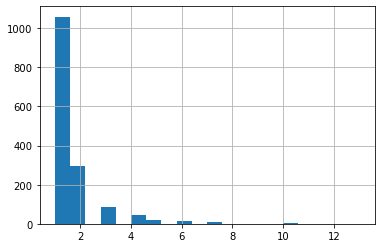

In [17]:
queerphobiaSubset['T1 x A1 Count'].hist(bins = 20)

In [18]:
queerphobiaSubset['T1 x A1 Count'].value_counts()

1     1059
2      294
3       88
4       46
5       18
6       14
7        7
10       2
8        1
13       1
Name: T1 x A1 Count, dtype: int64

<AxesSubplot:>

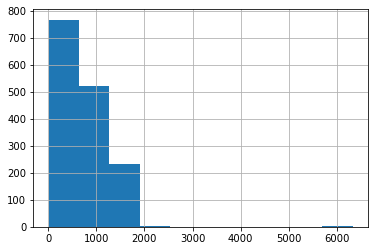

In [145]:
queerphobiaSubset['Number of Words'].hist(bins=10)

## Analyze length of arguments and reduce to comments < 500 words

In [62]:
queerphobiaSubset['Number of Words'] = queerphobiaSubset.progress_apply(lambda row: countWords(row['annotationComment']),axis=1)

100%|████████████████████████████████████████████████████████████████████████████| 1530/1530 [00:00<00:00, 1825.70it/s]


In [85]:
queerphobiaSubset = queerphobiaSubset[queerphobiaSubset['Number of Words'] < 500]
len(queerphobiaSubset)

## Create annotation ready dataframe per found biased tuple

In [87]:
def perFoundTupleFrame(df):
    result = []
    for index, row in df.iterrows():
        rowList = []
        if row['T1 x A1 Count'] > 1:
            for i in range(row['T1 x A1 Count']):
                rowList = []
                rowList.append(row['index'])
                rowList.append(row['title'])
                rowList.append(row['annotationComment'])
                rowList.append(row['T1 x A1 Sentences'][i])
                rowList.append(row['T1 x A1 Tuples Found'][i])
                result.append(rowList)
        else: 
            rowList.append(row['index'])
            rowList.append(row['title'])
            rowList.append(row['annotationComment'])
            rowList.append(row['T1 x A1 Sentences'])
            rowList.append(row['T1 x A1 Tuples Found'])
            result.append(rowList)
            
    resultFrame = pd.DataFrame(result, columns=['index', 'title', 'annotationComment', 'T1 x A1 Sentences', 'T1 x A1 Tuples Found'])
    return resultFrame

def createStringFromList(entry):
    if isinstance(entry, list):
        returnString = entry[0]
    else: 
        returnString = entry
    return returnString

In [88]:
queerphobiaAnnotationFrame = perFoundTupleFrame(queerphobiaSubset)
queerphobiaAnnotationFrame['T1 x A1 Sentences'] = queerphobiaAnnotationFrame.progress_apply(lambda row: createStringFromList(row['T1 x A1 Sentences']),axis=1)
queerphobiaAnnotationFrame['T1 x A1 Tuples Found'] = queerphobiaAnnotationFrame.progress_apply(lambda row: createStringFromList(row['T1 x A1 Tuples Found']),axis=1)
queerphobiaAnnotationFrame['Biased Sentence'] = ''
queerphobiaAnnotationFrame['Biased Comment'] = ''
queerphobiaAnnotationFrame['Comment'] = ''

In [93]:
len(queerphobiaAnnotationFrame)

889

In [ ]:
# Save to csv
#queerphobiaAnnotationFrame.to_csv('queerphobia_annotation_frame.csv', encoding='UTF-8')

# Create sample for IAA
#ten_percent_sample = queerphobiaAnnotationFrame.sample(frac=0.1, replace=False, random_state=1)
#ten_percent_sample.to_csv('queerphobia_iaa_frame.csv')

## Analyze found tuples

In [96]:
queerphobiaAnnotationFrame['T1 x A1 Tuples Found'].value_counts().nlargest(20)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


(sin, gay)                  77
[(sin, gay)]                64
[(sin, homosexual)]         38
[(immoral, gay)]            37
[(immoral, homosexual)]     30
(immoral, homosexual)       24
(sin, homosexual)           23
(disease, gay)              20
[(disease, gay)]            18
(sinful, homosexual)        18
(pedophile, homosexual)     16
(repulsive, gay)            15
(immoral, gay)              12
(pedophile, gay)            12
(polygamous, gay)           11
(asexual, bisexual)         11
[(sin, homosexuals)]        10
[(immoral, homosexuals)]     9
(immoral, homosexuals)       9
(asexual, gay)               9
Name: T1 x A1 Tuples Found, dtype: int64

In [79]:
queerphobiaAnnotationFrame['T1'].value_counts()

gay             978
homosexual      740
homosexuals     307
gays            127
transgender      72
lesbian          42
bisexual         37
lesbians         18
bisexuals         9
transgenders      8
queer             7
transsexuals      4
pansexual         4
transsexual       3
lgbtq             3
Name: T1, dtype: int64

In [80]:
queerphobiaAnnotationFrame['A1'] = queerphobiaAnnotationFrame.progress_apply(lambda row: row['T1 x A1 Tuples Found'][0],axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 2359/2359 [00:00<00:00, 78633.41it/s]


In [82]:
queerphobiaAnnotationFrame['A1'].value_counts()

sin                  555
immoral              472
disease              259
sinful               109
pedophile             89
emotional             80
promiscuous           76
alcohol               66
mental disorder       62
sexual abuse          54
asexual               49
polygamous            46
mentally ill          45
perverts              44
adultery              42
weird                 38
weak                  35
repulsive             28
criminal              28
strange               26
pervert               22
fashion               21
faggot                13
confuse               13
flamboyant            13
prostitute             9
predator               8
dramatic               8
sexual predator        6
serial killer          5
loser                  4
sensitive              4
drag queen             3
insecure               3
weak minded            3
drug addict            3
submissive             2
theatre                2
sexually abnormal      2
arts                   2


# Analyze comments and sentences extracted for Islamophobia bias

In [70]:
#Create subset of biased sentences and comments
islamophobiaSubset = df_debate_islamophobia_SW10[df_debate_islamophobia_SW10['T1 x A1 Count'] > 0]
len(islamophobiaSubset)

2617

<AxesSubplot:>

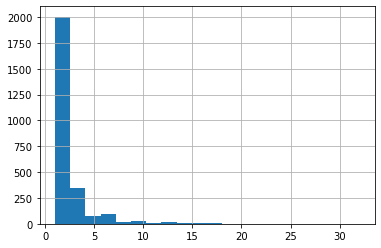

In [18]:
# Plot number of biased sentences per biased comment
islamophobiaSubset['T1 x A1 Count'].hist(bins = 20)

## Analyze length of arguments and reduce to comments < 500 words

In [59]:
# Calculate number of words per argument
islamophobiaSubset['Number of Words'] = islamophobiaSubset.progress_apply(lambda row: countWords(row['annotationComment']),axis=1)
islamophobiaSubset = islamophobiaSubset[islamophobiaSubset['Number of Words'] < 500]
len(islamophobiaSubset)

1101

## Create annotation ready dataframe per found biased tuple

In [39]:
islamophobiaAnnotationFrame = perFoundTupleFrame(islamophobiaSubset)
islamophobiaAnnotationFrame['T1 x A1 Sentences'] = islamophobiaAnnotationFrame.progress_apply(lambda row: createStringFromList(row['T1 x A1 Sentences']),axis=1)
islamophobiaAnnotationFrame['T1 x A1 Tuples Found'] = islamophobiaAnnotationFrame.progress_apply(lambda row: createStringFromList(row['T1 x A1 Tuples Found']),axis=1)
islamophobiaAnnotationFrame['Biased Sentence'] = ''
islamophobiaAnnotationFrame['Biased Comment'] = ''
islamophobiaAnnotationFrame['Comment'] = ''
len(islamophobiaAnnotationFrame)

In [51]:
# Save to csv
#islamophobiaAnnotationFrame.to_csv('islamophobia_annotation_frame.csv', encoding='UTF-8')

# Create sample for IAA
#five_percent_sample = islamophobiaAnnotationFrame.sample(frac=0.05, replace=False, random_state=1)
#five_percent_sample.to_csv('islamophobia_iaa_frame.csv')
len(five_percent_sample)

94

## Analyze found tuples

In [78]:
islamophobiaSubset['T1 x A1 Tuples Found'].value_counts().nlargest(20)

(terrorism, islam)      293
(violence, islam)       246
(war, muslims)          223
(radical, islam)        220
(terrorism, islamic)    217
(war, islam)            211
(violent, islam)        198
(radical, muslims)      197
(terrorist, muslims)    183
(terrorist, muslim)     166
(terrorist, islamic)    159
(attack, muslims)       149
(terrorism, muslims)    138
(hate, muslims)         130
(violence, muslims)     121
(threat, islam)         114
(radical, muslim)       111
(radical, islamic)      110
(war, islamic)          104
(war, muslim)           100
Name: T1 x A1 Tuples Found, dtype: int64

In [80]:
islamophobiaSubset['A1'] = religiousSubset.progress_apply(lambda row: row['T1 x A1 Tuples Found'][0],axis=1)
islamophobiaSubset['T1'] = religiousSubset.progress_apply(lambda row: row['T1 x A1 Tuples Found'][1],axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 5734/5734 [00:00<00:00, 84321.07it/s]


In [82]:
islamophobiaSubset['A1'].value_counts().nlargest(20)

war          769
terrorism    753
radical      644
terrorist    615
violence     499
violent      389
attack       368
hate         336
threat       258
extremist    201
murder       136
enemies      129
enemy         96
dangerous     90
hijab         73
slaves        57
hostile       55
bomb          46
oppressed     44
rich          35
Name: A1, dtype: int64

In [83]:
islamophobiaSubset['T1'].value_counts().nlargest(20)

islam       1821
muslims     1621
islamic     1006
muslim       952
arab         223
arabs        106
islamism       5
Name: T1, dtype: int64